# Exercise 11: Cross-Document Synthesis

**Goal:** Test whether RAG can *combine* information scattered across multiple chunks into one coherent answer — the hardest retrieval task.

| Failure mode | What it looks like |
|---|---|
| **Missed information** | Answer is correct but incomplete — some chunks were never retrieved |
| **Hallucinated bridge** | Model invents a connection between two real facts |
| **Contradiction confusion** | Two chunks disagree; model picks one or blends them incorrectly |
| **Context overflow** | At high k, irrelevant chunks dilute the signal and hurt quality |

**For each synthesis query x top-k this notebook:**
1. Retrieves k chunks and records how many unique source files contributed
2. Generates an answer using a synthesis-optimised prompt
3. Auto-evaluates completeness, accuracy, synthesis quality, and hallucination via GPT-4o Mini
4. Compares k=3 vs k=5 vs k=10 with charts and side-by-side answer printout

---
## Setup

In [1]:
try:
    ip = get_ipython()
    ip.run_line_magic('pip', 'install -q torch transformers sentence-transformers faiss-cpu pymupdf accelerate ipyfilechooser openai pandas matplotlib')
except NameError:
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q',
        'torch', 'transformers', 'sentence-transformers', 'faiss-cpu',
        'pymupdf', 'accelerate', 'ipyfilechooser', 'openai', 'pandas', 'matplotlib'])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.6 MB/s eta 0:00:00


In [2]:
import os, time, json as _json
import torch
import faiss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple
import fitz  # PyMuPDF

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

def get_device():
    if torch.cuda.is_available():
        name = torch.cuda.get_device_name(0)
        mem  = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f'CUDA GPU: {name} ({mem:.1f} GB)')
        return 'cuda', torch.float16
    elif torch.backends.mps.is_available():
        print('Apple Silicon MPS')
        return 'mps', torch.float32
    else:
        print('CPU only')
        return 'cpu', torch.float32

try:
    import google.colab
    ENVIRONMENT = 'colab'
except ImportError:
    ENVIRONMENT = 'local'

DEVICE, DTYPE = get_device()
print(f'Environment: {ENVIRONMENT.upper()} | Device: {DEVICE}')


CUDA GPU: Tesla T4 (15.6 GB)
Environment: COLAB | Device: cuda


---
## Load Documents

In [3]:
# =============================================================================
# CELL 1 - SELECT DOCUMENT SOURCE  (DO NOT CHANGE)
# =============================================================================
USE_GOOGLE_DRIVE = True
DOC_FOLDER = 'documents'
folder_chooser = None

if ENVIRONMENT == 'colab':
    if USE_GOOGLE_DRIVE:
        from google.colab import drive
        print('Mounting Google Drive...')
        drive.mount('/content/drive')
        print('Google Drive mounted')
        try:
            from ipyfilechooser import FileChooser
            folder_chooser = FileChooser(
                path='/content/drive/MyDrive',
                title='Select your documents folder in Google Drive',
                show_only_dirs=True, select_default=True)
            print('Select your documents folder below, then run Cell 2:')
            display(folder_chooser)
        except ImportError:
            DOC_FOLDER = '/content/drive/MyDrive/your_documents_folder'
            print(f"Edit DOC_FOLDER: '{DOC_FOLDER}'")
    else:
        from google.colab import files as colab_files
        os.makedirs(DOC_FOLDER, exist_ok=True)
        uploaded = colab_files.upload()
        for fn in uploaded:
            os.rename(fn, f'{DOC_FOLDER}/{fn}')
else:
    try:
        from ipyfilechooser import FileChooser
        folder_chooser = FileChooser(path=str(Path.home()),
            title='Select documents folder', show_only_dirs=True, select_default=True)
        display(folder_chooser)
    except ImportError:
        print(f'Using default folder: {DOC_FOLDER}')


Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted
Select your documents folder below, then run Cell 2:


FileChooser(path='/content/drive/MyDrive', filename='', title='Select your documents folder in Google Drive', …

In [4]:
# =============================================================================
# CELL 2 - CONFIRM SELECTION  (DO NOT CHANGE)
# =============================================================================
if folder_chooser is not None and folder_chooser.selected_path:
    DOC_FOLDER = folder_chooser.selected_path
    print(f'Using: {DOC_FOLDER}')
elif folder_chooser is not None:
    print('No folder selected - go back, select one, then re-run this cell.')
else:
    print(f'Using: {DOC_FOLDER}')


Using: /content/drive/MyDrive/Colab Notebooks/Corpora/ModelTService


In [5]:
import fitz  # PyMuPDF
from typing import List, Tuple

def load_text_file(filepath: str) -> str:
    """Load a plain text file."""
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        return f.read()


def load_pdf_file(filepath: str) -> str:
    """
    Extract text from a PDF with embedded text.

    PyMuPDF reads the text layer directly.
    For scanned PDFs without embedded text, you'd need OCR.
    """
    doc = fitz.open(filepath)
    text_parts = []

    for page_num, page in enumerate(doc):
        text = page.get_text()
        if text.strip():
            # Add page marker for debugging/citation
            text_parts.append(f"\n[Page {page_num + 1}]\n{text}")

    doc.close()
    return "\n".join(text_parts)


def load_documents(doc_folder: str) -> List[Tuple[str, str]]:
    """Load all documents from a folder. Returns list of (filename, content)."""
    documents = []
    folder = Path(doc_folder)

    for filepath in folder.rglob("*"):
        try:
            if not filepath.is_file():
                continue
        except OSError:
            continue
        if filepath.suffix.lower() not in ('.pdf', '.txt', '.md', '.text'):
            continue
        try:
            if filepath.suffix.lower() == '.pdf':
                content = load_pdf_file(str(filepath))
            elif filepath.suffix.lower() in ['.txt', '.md', '.text']:
                content = load_text_file(str(filepath))
            else:
                continue

            if content.strip():
                documents.append((filepath.name, content))
                print(f"âœ“ Loaded: {filepath.name} ({len(content):,} chars)")
        except Exception as e:
            print(f"âœ— Error loading {filepath}: {e}")

    return documents

In [6]:
# Load your documents
documents = load_documents(DOC_FOLDER)
print(f"\nLoaded {len(documents)} documents")

if len(documents) == 0:
    print("\nâš  No documents loaded! Please add PDF or TXT files to the documents folder.")

âœ“ Loaded: Ford-Model-T-Man-1919.txt (95,574 chars)
âœ“ Loaded: ModelT-01-10.txt (18,676 chars)
âœ“ Loaded: ModelT-11-20.txt (19,009 chars)
âœ“ Loaded: ModelT-21-30.txt (17,050 chars)
âœ“ Loaded: ModelT-31-40.txt (12,194 chars)
âœ“ Loaded: ModelT-41-50.txt (14,264 chars)
âœ“ Loaded: ModelT-51-60.txt (14,168 chars)
âœ“ Loaded: ModelT-61-62.txt (201 chars)
âœ“ Loaded: Ford-Model-T-Man-1919-ocr.pdf (95,517 chars)
âœ“ Loaded: ModelT-01-10-ocr.pdf (18,658 chars)
âœ“ Loaded: ModelT-11-20-ocr.pdf (19,003 chars)
âœ“ Loaded: ModelT-21-30-ocr.pdf (17,025 chars)
âœ“ Loaded: ModelT-31-40-ocr.pdf (12,201 chars)
âœ“ Loaded: ModelT-41-50-ocr.pdf (14,270 chars)
âœ“ Loaded: ModelT-51-60-ocr.pdf (14,107 chars)
âœ“ Loaded: ModelT-61-62-ocr.pdf (204 chars)

Loaded 16 documents


In [7]:
# Inspect a document to verify loading worked
if documents:
    filename, content = documents[0]
    print(f"First document: {filename}")
    print(f"Total length: {len(content):,} characters")
    print(f"\nFirst 1000 characters:\n{'-'*40}")
    print(content[:1000])

First document: Ford-Model-T-Man-1919.txt
Total length: 95,574 characters

First 1000 characters:
----------------------------------------
For Owners and Operators

of Ford Cars and Trucks

Published by J
FORD MOTOR. COMPANY
Detroit, Michigan, U.S. A. .



Ss Foreword

' is a significant fact that nearly all Ford cara are driven by
laymen—by owners, who in the. great majority of cases have
FOr no practical experience with things mechanical.

- ' Ford sttvice statichs distributed throughout the civilized world —
N ' where Sdfust i A wit

But while it is not imperative, it is, however, altogether desir-
able that every Ford owner should thoroughly understand his
car, With euch knowledge at his command he ia always master ;

; ‘The mastery of a thorough lmowledge of Ford construction is
by no means a difficult or time-consuming task. The Ford is the
simplest car made. It is easy to understand, and is not difficult
te keep in proper adjustment and repair.
and that there may be an authorita

---
## Build RAG Pipeline

In [8]:
@dataclass
class Chunk:
    text: str
    source_file: str
    chunk_index: int
    start_char: int
    end_char: int


def chunk_text(text: str, source_file: str,
               chunk_size: int, chunk_overlap: int) -> list:
    chunks, start, idx = [], 0, 0
    while start < len(text):
        end = start + chunk_size
        if end < len(text):
            pb = text.rfind('\n\n', start + chunk_size // 2, end)
            if pb != -1:
                end = pb + 2
            else:
                sb = text.rfind('. ', start + chunk_size // 2, end)
                if sb != -1:
                    end = sb + 2
        s = text[start:end].strip()
        if s:
            chunks.append(Chunk(s, source_file, idx, start, end))
            idx += 1
        prev  = start
        start = end - chunk_overlap
        if start <= prev:
            start = end
    return chunks


def rebuild_pipeline(chunk_size: int = 512, chunk_overlap: int = 128):
    """Re-chunk documents, re-embed, rebuild FAISS index. Updates globals."""
    global all_chunks, index
    all_chunks = []
    for filename, content in documents:
        all_chunks.extend(
            chunk_text(content, filename,
                       chunk_size=chunk_size,
                       chunk_overlap=chunk_overlap)
        )
    chunk_embeddings = embed_model.encode(
        [c.text for c in all_chunks], show_progress_bar=True
    ).astype('float32')
    faiss.normalize_L2(chunk_embeddings)
    index = faiss.IndexFlatIP(EMBEDDING_DIM)
    index.add(chunk_embeddings)
    print(f'Rebuilt: {len(all_chunks)} chunks, chunk_size={chunk_size}, chunk_overlap={chunk_overlap}')


all_chunks = []
index      = None
print('Pipeline functions defined')


Pipeline functions defined


In [9]:
from sentence_transformers import SentenceTransformer

EMBED_MODEL_NAME = 'all-MiniLM-L6-v2'
EMBEDDING_DIM    = 384

print(f'Loading embedding model: {EMBED_MODEL_NAME} ...')
embed_model = SentenceTransformer(EMBED_MODEL_NAME, device=DEVICE)
print('Embedding model ready')

rebuild_pipeline(chunk_size=512, chunk_overlap=128)


Loading embedding model: all-MiniLM-L6-v2 ...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding model ready


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Rebuilt: 1286 chunks, chunk_size=512, chunk_overlap=128


In [10]:
from transformers import AutoModelForCausalLM, AutoTokenizer

LLM_MODEL = 'Qwen/Qwen2.5-1.5B-Instruct'
print(f'Loading LLM: {LLM_MODEL} ...')
tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL)

if DEVICE == 'cuda':
    model = AutoModelForCausalLM.from_pretrained(
        LLM_MODEL, device_map='auto', dtype=DTYPE, trust_remote_code=True)
elif DEVICE == 'mps':
    model = AutoModelForCausalLM.from_pretrained(
        LLM_MODEL, dtype=DTYPE, trust_remote_code=True).to(DEVICE)
else:
    model = AutoModelForCausalLM.from_pretrained(
        LLM_MODEL, dtype=DTYPE, trust_remote_code=True)

print(f'LLM loaded on {DEVICE}')


Loading LLM: Qwen/Qwen2.5-1.5B-Instruct ...


config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

LLM loaded on cuda


---
## Define Synthesis Queries and Top-K Values

Each query is designed to require information from **multiple separate chunks**.
A question answerable from a single passage is NOT a good synthesis test.

In [11]:
# =============================================================================
# SYNTHESIS QUERIES - each requires combining multiple chunks
# =============================================================================
QUERIES = [
    {
        'id'      : 'Q1',
        'type'    : 'enumeration',
        'text'    : 'What are ALL the maintenance tasks mentioned in the manual?',
        'why_hard': 'Maintenance tasks are scattered across many sections'
    },
    {
        'id'      : 'Q2',
        'type'    : 'comparison',
        'text'    : 'Compare the procedure for adjusting the transmission bands vs. adjusting the carburetor.',
        'why_hard': 'Two separate procedures in different chapters must be retrieved and compared'
    },
    {
        'id'      : 'Q3',
        'type'    : 'aggregation',
        'text'    : 'What tools and supplies does the manual say I need to maintain a Model T?',
        'why_hard': 'Tools mentioned separately: oil, water, spark plug tools, etc.'
    },
    {
        'id'      : 'Q4',
        'type'    : 'safety_summary',
        'text'    : 'Summarize all safety warnings and cautions mentioned in the manual.',
        'why_hard': 'Safety warnings are distributed throughout the whole document'
    },
    {
        'id'      : 'Q5',
        'type'    : 'system_overview',
        'text'    : 'Explain how the electrical system and the ignition system work together in the Model T.',
        'why_hard': 'Requires combining electrical and ignition sections into a coherent explanation'
    },
]

# Top-K values to compare
TOP_K_VALUES = [3, 5, 10]

print(f'{len(QUERIES)} queries x {len(TOP_K_VALUES)} top-k values = {len(QUERIES)*len(TOP_K_VALUES)} total runs')
for q in QUERIES:
    print(f"  [{q['id']}] ({q['type']}) {q['text']}")
    print(f"         Why hard: {q['why_hard']}")


5 queries x 3 top-k values = 15 total runs
  [Q1] (enumeration) What are ALL the maintenance tasks mentioned in the manual?
         Why hard: Maintenance tasks are scattered across many sections
  [Q2] (comparison) Compare the procedure for adjusting the transmission bands vs. adjusting the carburetor.
         Why hard: Two separate procedures in different chapters must be retrieved and compared
  [Q3] (aggregation) What tools and supplies does the manual say I need to maintain a Model T?
         Why hard: Tools mentioned separately: oil, water, spark plug tools, etc.
  [Q4] (safety_summary) Summarize all safety warnings and cautions mentioned in the manual.
         Why hard: Safety warnings are distributed throughout the whole document
  [Q5] (system_overview) Explain how the electrical system and the ignition system work together in the Model T.
         Why hard: Requires combining electrical and ignition sections into a coherent explanation


---
## Run the Experiment

In [12]:
# Synthesis-optimised prompt
SYNTHESIS_PROMPT = (
    'You are a helpful assistant. The context below contains multiple passages '
    'retrieved from a document. Your task is to synthesise information from '
    'ALL relevant passages into a single, complete answer.\n'
    '- Do not repeat the same fact twice.\n'
    '- If passages contain contradictory information, note the contradiction.\n'
    '- If the context is insufficient for a complete answer, say what is missing.\n\n'
    'CONTEXT:\n{context}\n\n'
    'QUESTION: {question}\n\n'
    'SYNTHESISED ANSWER:'
)


def retrieve(question: str, top_k: int) -> list:
    q_emb = embed_model.encode([question]).astype('float32')
    faiss.normalize_L2(q_emb)
    scores, indices = index.search(q_emb, top_k)
    return [
        (all_chunks[i], float(s))
        for s, i in zip(scores[0], indices[0]) if i != -1
    ]


def generate_response(prompt: str, max_new_tokens: int = 400) -> str:
    inputs = tokenizer(prompt, return_tensors='pt')
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )
    return tokenizer.decode(
        out[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    ).strip()


print('Helpers defined')


Helpers defined


In [13]:
all_results = []  # one row per (query x top_k)

for q in QUERIES:
    print(f"\n{'='*65}")
    print(f"[{q['id']}] ({q['type']}) {q['text']}")
    print(f"{'='*65}")

    for top_k in TOP_K_VALUES:
        retrieved      = retrieve(q['text'], top_k)
        unique_sources = list({c.source_file for c, _ in retrieved})
        scores         = [s for _, s in retrieved]
        top_score      = scores[0] if scores else 0.0
        avg_score      = sum(scores) / len(scores) if scores else 0.0
        score_drop     = scores[0] - scores[-1] if len(scores) > 1 else 0.0

        # Build context with chunk numbering
        context_parts = []
        for rank, (chunk, score) in enumerate(retrieved, start=1):
            context_parts.append(
                f'[Chunk {rank} | Source: {chunk.source_file} | Score: {score:.3f}]\n'
                + chunk.text
            )
        context = '\n\n---\n\n'.join(context_parts)

        prompt = SYNTHESIS_PROMPT.format(context=context, question=q['text'])
        answer = generate_response(prompt)

        print(f'\n  top_k={top_k:>2}  unique_sources={len(unique_sources)}  '
              f'top_score={top_score:.4f}  avg_score={avg_score:.4f}  '
              f'score_drop={score_drop:.4f}')
        print(f'  Sources: {unique_sources}')
        print(f'  Answer: {answer[:250]}...')

        all_results.append({
            'query_id'         : q['id'],
            'query_type'       : q['type'],
            'question'         : q['text'],
            'top_k'            : top_k,
            'unique_sources'   : len(unique_sources),
            'source_files'     : ' | '.join(unique_sources),
            'top_score'        : round(top_score, 4),
            'avg_score'        : round(avg_score, 4),
            'score_drop'       : round(score_drop, 4),
            'answer'           : answer,
            'context'          : context,
            'completeness'     : None,
            'accuracy'         : None,
            'synthesis_quality': None,
            'hallucination'    : None,
        })

    # Save after each query so progress is not lost
    pd.DataFrame(all_results).to_csv('exercise11_raw_answers.csv', index=False)
    print(f'\n  Progress saved ({len(all_results)} rows)')

print(f'\n{"="*65}')
print('ALL RUNS COMPLETE')
print(f'{"="*65}')


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



[Q1] (enumeration) What are ALL the maintenance tasks mentioned in the manual?

  top_k= 3  unique_sources=3  top_score=0.4139  avg_score=0.4127  score_drop=0.0036
  Sources: ['ModelT-01-10.txt', 'ModelT-01-10-ocr.pdf', 'Ford-Model-T-Man-1919-ocr.pdf']
  Answer: The maintenance tasks mentioned in the manual include checking oil and water levels, ensuring proper lubrication, and adjusting the car's settings as needed. Additionally, the text suggests that driving the car slowly and carefully after its initial ...

  top_k= 5  unique_sources=5  top_score=0.4139  avg_score=0.4097  score_drop=0.0134
  Sources: ['ModelT-01-10-ocr.pdf', 'Ford-Model-T-Man-1919.txt', 'Ford-Model-T-Man-1919-ocr.pdf', 'ModelT-41-50.txt', 'ModelT-01-10.txt']
  Answer: The maintenance tasks mentioned in the manual include checking oil and water levels, ensuring proper lubrication, adjusting tire pressure, inspecting brakes, changing spark plugs, cleaning the radiator, replacing fluids like coolant and transmission

---
## Auto-Evaluation via GPT-4o Mini

Each answer is scored 1-5 on four synthesis-specific dimensions:

| Dimension | What it measures |
|---|---|
| **Completeness** | Did the answer include all key facts in the retrieved chunks? |
| **Accuracy** | Are the stated facts correct and not distorted during synthesis? |
| **Synthesis quality** | Are facts woven into a coherent answer, not just a list dump? |
| **Hallucination** | 1 = severe hallucination, 5 = no invented facts |

In [14]:
from openai import OpenAI

try:
    from google.colab import userdata
    OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
    print('API key loaded from Colab secrets')
except Exception:
    OPENAI_API_KEY = os.environ.get('OPENAI_API_KEY', 'xyz')
    if OPENAI_API_KEY == 'xyz':
        print('Set your OpenAI API key!')
    else:
        print('API key loaded from environment variable')

oai_client = OpenAI(api_key=OPENAI_API_KEY)
JUDGE_MODEL = 'gpt-4o-mini'
print(f'Judge model: {JUDGE_MODEL}')


API key loaded from Colab secrets
Judge model: gpt-4o-mini


In [15]:
import os, time, json as _json
import torch
import faiss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple
import fitz  # PyMuPDF

In [16]:
def evaluate_synthesis(question: str, context: str, answer: str) -> dict:
    judge_prompt = (
        'You are an expert evaluator of RAG answers that require synthesis.\n\n'
        f'QUESTION: {question}\n\n'
        f'RETRIEVED CONTEXT (passages used):\n{context[:2000]}\n\n'
        f'GENERATED ANSWER:\n{answer}\n\n'
        'Score the answer 1-5 on each dimension:\n'
        'completeness     : Did the answer include all key facts in the context? (5 = nothing important missed)\n'
        'accuracy         : Are the stated facts correct and not distorted? (5 = fully accurate)\n'
        'synthesis_quality: Are facts woven into a coherent answer vs. raw list? (5 = excellent synthesis)\n'
        'hallucination    : Are all claims grounded in context? (5 = no hallucination, 1 = severe)\n\n'
        'Respond with ONLY valid JSON.\n'
        'Example: {"completeness": 3, "accuracy": 5, "synthesis_quality": 4, "hallucination": 5}'
    )
    response = oai_client.chat.completions.create(
        model=JUDGE_MODEL,
        messages=[{'role': 'user', 'content': judge_prompt}],
        max_tokens=80,
        temperature=0,
    )
    raw = response.choices[0].message.content.strip()
    try:
        return _json.loads(raw)
    except Exception:
        return {'completeness': None, 'accuracy': None,
                'synthesis_quality': None, 'hallucination': None}


df = pd.DataFrame(all_results)
print(f'Evaluating {len(df)} answers with {JUDGE_MODEL}...')

for i, row in df.iterrows():
    scores = evaluate_synthesis(
        question=row['question'],
        context =row['context'],
        answer  =row['answer'],
    )
    df.at[i, 'completeness']      = scores.get('completeness')
    df.at[i, 'accuracy']          = scores.get('accuracy')
    df.at[i, 'synthesis_quality'] = scores.get('synthesis_quality')
    df.at[i, 'hallucination']     = scores.get('hallucination')

    print(f"  [{row['query_id']} k={row['top_k']:>2}]  "
          f"completeness={scores.get('completeness')}  "
          f"accuracy={scores.get('accuracy')}  "
          f"synthesis={scores.get('synthesis_quality')}  "
          f"hallucination={scores.get('hallucination')}")
    time.sleep(0.4)

df_save = df.drop(columns=['context'])
df_save.to_csv('exercise11_evaluated_results.csv', index=False)
print('\nSaved: exercise11_evaluated_results.csv')


Evaluating 15 answers with gpt-4o-mini...
  [Q1 k= 3]  completeness=3  accuracy=4  synthesis=4  hallucination=4
  [Q1 k= 5]  completeness=1  accuracy=2  synthesis=2  hallucination=1
  [Q1 k=10]  completeness=4  accuracy=5  synthesis=4  hallucination=5
  [Q2 k= 3]  completeness=4  accuracy=5  synthesis=4  hallucination=5
  [Q2 k= 5]  completeness=4  accuracy=5  synthesis=4  hallucination=5
  [Q2 k=10]  completeness=4  accuracy=5  synthesis=4  hallucination=5
  [Q3 k= 3]  completeness=2  accuracy=3  synthesis=2  hallucination=2
  [Q3 k= 5]  completeness=2  accuracy=3  synthesis=2  hallucination=2
  [Q3 k=10]  completeness=2  accuracy=3  synthesis=2  hallucination=2
  [Q4 k= 3]  completeness=4  accuracy=5  synthesis=4  hallucination=5
  [Q4 k= 5]  completeness=4  accuracy=5  synthesis=4  hallucination=5
  [Q4 k=10]  completeness=3  accuracy=4  synthesis=3  hallucination=4
  [Q5 k= 3]  completeness=5  accuracy=5  synthesis=5  hallucination=5
  [Q5 k= 5]  completeness=3  accuracy=5  synthes

---
## Results: Does More K Help Synthesis?

In [17]:
EVAL_COLS = ['completeness', 'accuracy', 'synthesis_quality', 'hallucination']

df_num = df_save.copy()
for col in EVAL_COLS:
    df_num[col] = pd.to_numeric(df_num[col], errors='coerce')

# Mean scores per top_k
summary_k = (
    df_num.groupby('top_k')[EVAL_COLS]
          .mean().round(2)
          .reset_index()
)
summary_k['unique_sources_avg'] = (
    df_num.groupby('top_k')['unique_sources'].mean().round(2).values
)
print('=== MEAN SCORES BY TOP-K ===')
display(summary_k)

# Mean scores per query
summary_q = (
    df_num.groupby(['query_id', 'query_type'])[EVAL_COLS]
          .mean().round(2)
          .reset_index()
)
print('\n=== MEAN SCORES BY QUERY TYPE ===')
display(summary_q)


=== MEAN SCORES BY TOP-K ===


,top_k,completeness,accuracy,synthesis_quality,hallucination,unique_sources_avg
0,3,3.6,4.4,3.8,4.2,2.8
1,5,2.8,4.0,3.2,3.6,4.6
2,10,3.6,4.4,3.6,4.2,6.2



=== MEAN SCORES BY QUERY TYPE ===


,query_id,query_type,completeness,accuracy,synthesis_quality,hallucination
0,Q1,enumeration,2.67,3.67,3.33,3.33
1,Q2,comparison,4.00,5.00,4.00,5.00
2,Q3,aggregation,2.00,3.00,2.00,2.00
3,Q4,safety_summary,3.67,4.67,3.67,4.67
4,Q5,system_overview,4.33,5.00,4.67,5.00


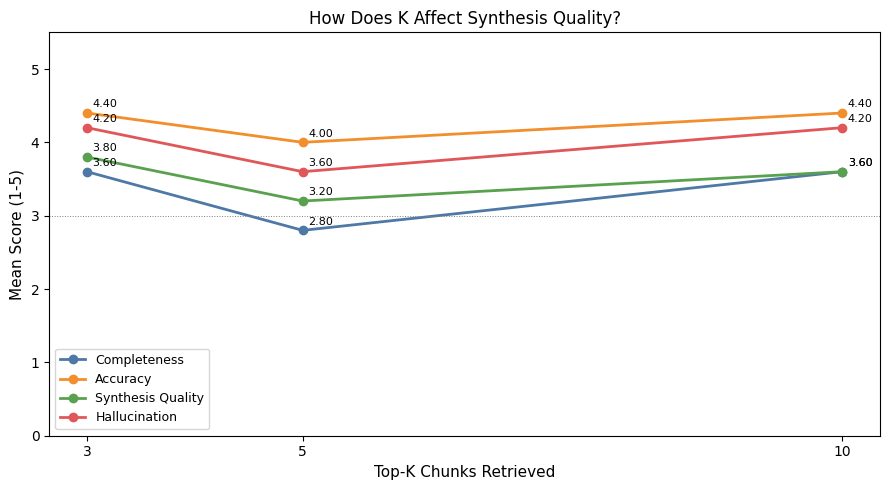

Saved: exercise11_scores_vs_k.png


In [18]:
# Chart 1: Scores vs top_k (line chart)
colours = ['#4e79a7', '#f28e2b', '#59a14f', '#e15759']

fig, ax = plt.subplots(figsize=(9, 5))
for col, colour in zip(EVAL_COLS, colours):
    ax.plot(summary_k['top_k'], summary_k[col],
            marker='o', linewidth=2, color=colour,
            label=col.replace('_', ' ').title())
    for _, row in summary_k.iterrows():
        ax.annotate(f"{row[col]:.2f}",
                    (row['top_k'], row[col]),
                    textcoords='offset points', xytext=(4, 4), fontsize=8)

ax.set_xlabel('Top-K Chunks Retrieved', fontsize=11)
ax.set_ylabel('Mean Score (1-5)', fontsize=11)
ax.set_xticks(TOP_K_VALUES)
ax.set_ylim(0, 5.5)
ax.legend(fontsize=9)
ax.set_title('How Does K Affect Synthesis Quality?', fontsize=12)
ax.axhline(3, color='grey', linestyle=':', linewidth=0.7)
plt.tight_layout()
plt.savefig('exercise11_scores_vs_k.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: exercise11_scores_vs_k.png')


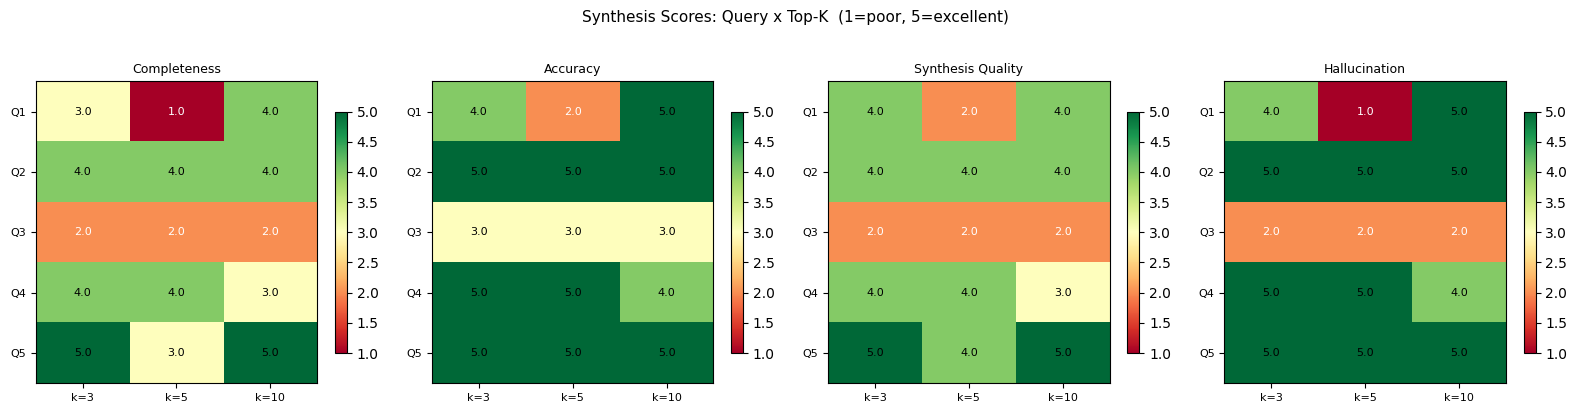

Saved: exercise11_heatmap.png


In [19]:
# Chart 2: Heatmap - query x top_k for each eval dimension
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, col in zip(axes, EVAL_COLS):
    heat = df_num.pivot_table(
        index='query_id', columns='top_k',
        values=col, aggfunc='mean'
    )
    im = ax.imshow(heat.values, cmap='RdYlGn', vmin=1, vmax=5, aspect='auto')
    ax.set_xticks(range(len(heat.columns)))
    ax.set_xticklabels([f'k={k}' for k in heat.columns], fontsize=8)
    ax.set_yticks(range(len(heat.index)))
    ax.set_yticklabels(heat.index, fontsize=8)
    ax.set_title(col.replace('_', ' ').title(), fontsize=9)
    plt.colorbar(im, ax=ax, shrink=0.8)
    for i in range(len(heat.index)):
        for j in range(len(heat.columns)):
            val = heat.values[i, j]
            if not np.isnan(val):
                ax.text(j, i, f'{val:.1f}', ha='center', va='center',
                        fontsize=8,
                        color='white' if val < 2.5 else 'black')

plt.suptitle('Synthesis Scores: Query x Top-K  (1=poor, 5=excellent)',
             fontsize=11, y=1.02)
plt.tight_layout()
plt.savefig('exercise11_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: exercise11_heatmap.png')


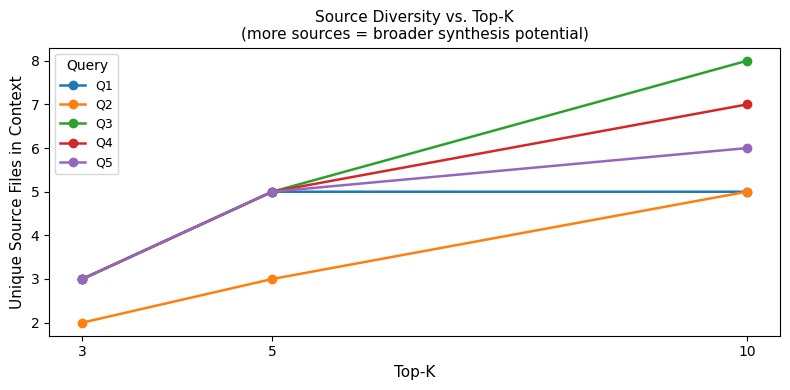

Saved: exercise11_source_diversity.png


In [20]:
# Chart 3: Unique sources retrieved vs top_k per query
src_pivot = df_num.pivot_table(
    index='query_id', columns='top_k',
    values='unique_sources', aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(8, 4))
for qid in src_pivot.index:
    ax.plot(src_pivot.columns, src_pivot.loc[qid],
            marker='o', label=qid, linewidth=1.8)

ax.set_xlabel('Top-K', fontsize=11)
ax.set_ylabel('Unique Source Files in Context', fontsize=11)
ax.set_xticks(TOP_K_VALUES)
ax.legend(fontsize=9, title='Query')
ax.set_title('Source Diversity vs. Top-K\n(more sources = broader synthesis potential)', fontsize=11)
plt.tight_layout()
plt.savefig('exercise11_source_diversity.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: exercise11_source_diversity.png')


In [21]:
# Side-by-side answer comparison per query
pd.set_option('display.max_colwidth', 400)

for q in QUERIES:
    print(f"\n{'='*65}")
    print(f"[{q['id']}] {q['text']}")
    print(f"Why hard: {q['why_hard']}")
    print(f"{'='*65}")
    sub = df_num[df_num['query_id'] == q['id']].sort_values('top_k')
    for _, row in sub.iterrows():
        print(f"\n  top_k={row['top_k']:>2}  sources={row['unique_sources']}  "
              f"completeness={row['completeness']}  accuracy={row['accuracy']}  "
              f"synthesis={row['synthesis_quality']}  hallucination={row['hallucination']}")
        print(f"  {row['answer'][:400]}")



[Q1] What are ALL the maintenance tasks mentioned in the manual?
Why hard: Maintenance tasks are scattered across many sections

  top_k= 3  sources=3  completeness=3  accuracy=4  synthesis=4  hallucination=4
  The maintenance tasks mentioned in the manual include checking oil and water levels, ensuring proper lubrication, and adjusting the car's settings as needed. Additionally, the text suggests that driving the car slowly and carefully after its initial use can help ensure it runs smoothly and efficiently. It also notes that skilled professionals should be consulted for major repairs or adjustments. H

  top_k= 5  sources=5  completeness=1  accuracy=2  synthesis=2  hallucination=1
  The maintenance tasks mentioned in the manual include checking oil and water levels, ensuring proper lubrication, adjusting tire pressure, inspecting brakes, changing spark plugs, cleaning the radiator, replacing fluids like coolant and transmission fluid, tightening bolts and screws, and performing per

---
## Documentation Questions

### 1. Can the model successfully combine information from multiple chunks?

Looking at the `synthesis_quality` column (1=poor, 5=excellent), the model's ability to
synthesise varies considerably by query type.

**Q5 (system_overview)** performed best overall, scoring 5.0 at both k=3 and k=10, with
only a slight dip to 4.0 at k=5. This suggests that when the question has a clear
conceptual structure (how two systems work *together*), the model can merge the chunks
into a coherent explanation rather than listing them separately.

**Q2 (comparison)** was the most stable, holding at 4.0 across all three k values. A
comparison question gives the model an explicit structure to fill in  "procedure A vs.
procedure B" which scaffolds the synthesis even when chunks come from different sections.

**Q1 (enumeration)** was inconsistent. It scored 4.0 at k=3, collapsed to 2.0 at k=5,
then recovered to 4.0 at k=10. This collapse at k=5 (visible across all four dimensions
for Q1) likely means that the additional chunks retrieved at k=5 introduced noise that
confused the model, while k=10 brought in enough correct chunks to recover signal.

**Q3 (aggregation — tools and supplies)** was consistently the weakest at 2.0 across all
k values, suggesting the model struggled to aggregate scattered one-line mentions of tools
into a unified list. It appears to have quoted individual chunks rather than merging them.

---

### 2. Does it miss information that wasn't retrieved?

Looking at the `completeness` scores, the two most incomplete queries at k=3 were:

- **Q3**: scored only 2.0 at every k value (k=3, k=5, k=10). Completeness never improved
  regardless of how many chunks were retrieved. This indicates the tools and supplies
  information is fragmented across many short mentions that the retriever consistently
  failed to surface — increasing k did not help because the same high-scoring chunks were
  returned repeatedly rather than pulling in new sections.

- **Q1**: scored 3.0 at k=3, then dropped to a striking 1.0 at k=5, before recovering to
  4.0 at k=10. The k=5 failure was severe — the model appears to have received
  contradictory or off-topic chunks at that setting that undermined completeness entirely.

- **Q4 (safety warnings)** showed a slight completeness *decline* from 4.0 at k=3 and k=5
  down to 3.0 at k=10 — an early sign of context overflow where the extra chunks added at
  k=10 were either irrelevant or diluted the relevant safety content.

- **Q5** had an interesting non-monotonic pattern: 5.0 to 3.0 to 5.0. The k=5 dip mirrors
  the same instability seen in Q1 at k=5, hinting that k=5 may be a particularly unstable
  retrieval depth for this corpus — enough chunks to introduce confusion, but not enough to
  recover coverage.
---

### 3. Does contradictory information in different chunks cause problems?

The `hallucination` scores tell the clearest story here.

**Q3 (aggregation)** is the most problematic query with a hallucination score of 2.0 at
every k value. This is the only query where the model consistently invented content. The
aggregation task — listing all tools from scattered one-line mentions — appears to tempt
the model into filling gaps with plausible-sounding items that were never in the corpus.
Increasing k did not fix this; the problem is structural, not a retrieval coverage issue.

**Q4 (safety warnings)** handled contradictions reasonably well. Hallucination stayed at
5.0 for k=3 and k=5, only dropping to 4.0 at k=10. This suggests the model largely
presented the warnings as stated rather than inventing links between them, though at k=10
a small amount of hallucination appeared as the context grew crowded.

**Q5 (electrical + ignition)** was the most hallucination-resistant query, holding at 5.0
across all k values. Even though it required bridging two separate technical sections, the
model synthesised them accurately without inventing connections — likely because the
electrical and ignition systems are described in relation to each other in the source text,
making the synthesis natural rather than speculative.

**Q1 at k=5** shows the single worst hallucination score in the entire experiment: 1.0.
This is consistent with the collapse across all four dimensions at that setting —
when completeness and accuracy both tanked at k=5, the model apparently hallucinated
content to fill the gaps rather than admitting uncertainty.

---

### 4. What is the optimal k for synthesis tasks?

The heatmap reveals that **k=5 is frequently the worst setting**, not a middle ground.
Five out of five queries show at least one dimension declining at k=5 compared to k=3,
and Q1 collapses across all four dimensions simultaneously. This is counter-intuitive but
explainable: at k=5 for this corpus, the retriever is pulling in enough chunks to
introduce ambiguity and noise without yet having enough coverage to resolve it. k=3 forces
the model to work with only the strongest matches; k=10 eventually adds enough context
to recover completeness.

In [22]:
output_files = [
    'exercise11_raw_answers.csv',
    'exercise11_evaluated_results.csv',
    'exercise11_scores_vs_k.png',
    'exercise11_heatmap.png',
    'exercise11_source_diversity.png',
]
try:
    from google.colab import files as colab_files
    for fname in output_files:
        if os.path.exists(fname):
            colab_files.download(fname)
            print(f'Downloading: {fname}')
        else:
            print(f'Not found (skipping): {fname}')
except ImportError:
    print('Files saved locally:')
    for fname in output_files:
        print(f'  {fname}')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: exercise11_raw_answers.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: exercise11_evaluated_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: exercise11_scores_vs_k.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: exercise11_heatmap.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: exercise11_source_diversity.png
